# NLP Bag-of-Words Exploratory Modeling: Kenya Focus

This notebook uses preprocessed .csv files from the Kiva Max Approver project, and uses word frequency analysis to attempt to predict loan funding status, with a focus on loans in Kenya. 

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# # #downloads
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

In [3]:
# set filenames

filename = ('data/kenya_pre_processed_nlp.csv')

In [4]:
# read in kenya data

kiva = pd.read_csv(filename).set_index('LOAN_ID').drop(columns = 'Unnamed: 0')

In [5]:
kiva.head()

,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,STATUS
LOAN_ID,,,,
1799331,"['dinnah', 'year', 'age', 'proud', 'mother', '...","['buy', 'farm', 'input', 'seed', 'fertilizer',...",['parent'],1
1294719,"['resy', 'married', 'woman', 'blessed', 'kid',...","['purchase', 'chick', 'poultry', 'feed']","['animal', 'womanowned', 'business', 'voluntee...",1
1595847,"['lavenda', 'happily', 'married', 'blessed', '...","['add', 'stock', 'beauty', 'product', 'salon']","['user_favorite', 'parent', 'womanowned', 'bus...",0
1139606,"['hadija', 'kiva', 'borrower', 'describes', 'h...","['buy', 'stock', 'vegetable', 'flour', 'sugar'...","['repeat', 'borrower', 'womanowned', 'business']",1
1813411,"['purity', 'aged', 'lovely', 'mother', 'child'...","['purchase', 'highquality', 'seed', 'nutrientr...",['nan'],1


In [6]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50011 entries, 1799331 to 1767038
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DESCRIPTION_TRANSLATED  50011 non-null  object
 1   LOAN_USE                50011 non-null  object
 2   TAGS                    50011 non-null  object
 3   STATUS                  50011 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [7]:
kiva['STATUS'].value_counts()

1    38993
0    11018
Name: STATUS, dtype: int64

In [8]:
kiva['STATUS'].value_counts(normalize=True)

1    0.779688
0    0.220312
Name: STATUS, dtype: float64

## Model Description_Translated Column

#### Model

In [9]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [10]:
#check for baseline
y.value_counts(normalize=True)

1    0.779688
0    0.220312
Name: STATUS, dtype: float64

In [11]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

#### Check Out Top Occuring Words with Count Vectorizer

In [12]:
cvec = CountVectorizer()

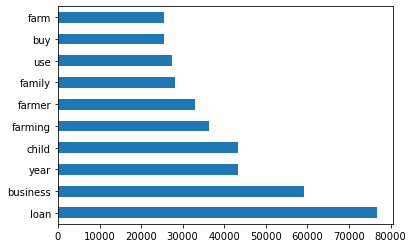

In [13]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

In [14]:
#this was added to the preprocessing stage

#  add in some stopwords - code inspired by varun
# my_stop = ['br', 'nan']
# stop_words = my_stop

### Run Through Classifiers

In [15]:
#create a list of the model classes to test
model_list = [
    LogisticRegression(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
]

#### CVEC

In [16]:
#vectorize features with ngram range 1,3
cvec = CountVectorizer(max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_results = pd.DataFrame(classifier_list)
desc_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.802140,0.797061,0.789417
1,GradientBoostingClassifier(),0.799415,0.794962,0.793816
2,RandomForestClassifier(),0.994426,0.787864,0.783118


Null Model is: 0.782635.


|  	| model_name 	| train_score 	| test_score 	| cv_score 	|
|-:	|-:	|-:	|-:	|-:	|
| 0 	| LogisticRegression() 	| 0.802140 	| 0.797061 	| 0.789417 	|
| 1 	| GradientBoostingClassifier() 	| 0.799415 	| 0.794962 	| 0.793816 	|
| 2 	| RandomForestClassifier() 	| 0.994426 	| 0.787864 	| 0.783118 	|

#### TVEC

In [17]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_tvec_results = pd.DataFrame(classifier_list)
desc_tvec_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.817561,0.802659,0.796416
1,GradientBoostingClassifier(),0.802514,0.797861,0.792866
2,RandomForestClassifier(),0.999775,0.792262,0.787368


The scores are slightly higher for the TfidfVectorizer

| model_name 	| train_score 	| test_score 	| cv_score 	|
|-:	|-:	|-:	|-:	|
| LogisticRegression() 	| 0.817561 	| 0.802659 	| 0.796416 	|
| GradientBoostingClassifier() 	| 0.802514 	| 0.797861 	| 0.792866 	|
| RandomForestClassifier() 	| 0.999775 	| 0.792262 	| 0.787368 	|

## Model LOAN_USE


In [24]:
#set up X and y

X = kiva['LOAN_USE']
y = kiva['STATUS']

In [25]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

### Check Out Top Occurring Words With CountVectorizer


In [26]:
cvec = CountVectorizer()

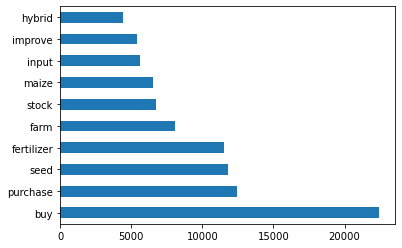

In [27]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

### Run Through the Classifiers

#### CVEC

In [28]:
#vectorize features
cvec = CountVectorizer(max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_results = pd.DataFrame(classifier_list)
loan_use_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.789492,0.788963,0.782094
1,GradientBoostingClassifier(),0.786818,0.786364,0.783693
2,RandomForestClassifier(),0.884773,0.771469,0.763747


| model_name 	| train_score 	| test_score 	| cv_score 	|
|-:	|-:	|-:	|-:	|
| LogisticRegression() 	| 0.789492 	| 0.788963 	| 0.782094 	|
| GradientBoostingClassifier() 	| 0.786818 	| 0.786364 	| 0.783693 	|
| RandomForestClassifier() 	| 0.884773 	| 0.771469 	| 0.763747 	|

#### TVEC

In [29]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_tvec_results = pd.DataFrame(classifier_list)
loan_use_tvec_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.791092,0.788963,0.784768
1,GradientBoostingClassifier(),0.789842,0.788463,0.784943
2,RandomForestClassifier(),0.896296,0.777567,0.771646


| model_name 	| train_score 	| test_score 	| cv_score 	|
|-:	|-:	|-:	|-:	|
| LogisticRegression() 	| 0.791092 	| 0.788963 	| 0.784768 	|
| GradientBoostingClassifier() 	| 0.789842 	| 0.788463 	| 0.784943 	|
| RandomForestClassifier() 	| 0.896296 	| 0.777567 	| 0.771646 	|

# Interpretation and Next Steps

*  The LOAN_USE column does not appear to be predictive. 

*  For the 'DESCRIPTION_TRANSLATED' column, the logistic regression model with TVEC produced a slight improvement over the null model, without dramatic overfitting like RF. Next steps are to 
     *  tune the LogReg model
     *  see if overfitting can be reduced in the Random Forest model, as it is able to capture a lot of the variance in the training data 

### Logistic Regression with TVEC

In [30]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [31]:
#check for baseline
y.value_counts(normalize=True)

1    0.779688
0    0.220312
Name: STATUS, dtype: float64

In [32]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

In [33]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [34]:
logreg = LogisticRegression(solver='liblinear', max_iter=800)
logreg.fit(X_train_tvec, y_train)
print(logreg.score(X_train_tvec,y_train), logreg.score(X_test_tvec,y_test))

0.8175614877024595 0.8028591422573228


In [40]:
#explore words and their coefficients 
coef_dict = {'coefficient': logreg.coef_[0], 'words': tvec.get_feature_names()}
coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by = 'coefficient', ascending=False, inplace=True, key = abs)

In [41]:
coef_df.head(20)

,coefficient,words
12664,-3.623961,man
23337,3.610894,widow
8348,3.498269,grew
20367,3.469934,single
15217,2.981590,north
23338,2.906562,widowed
7222,-2.803433,fifth
23121,2.710251,water
7598,-2.658149,fourth
1781,2.343346,biodigester


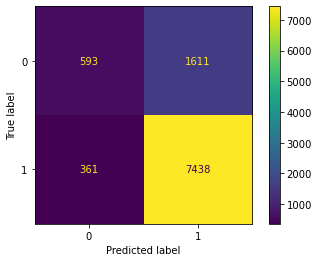

In [47]:
#get predictions 
preds = logreg.predict(X_test_tvec)

#plot confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot();

In [48]:
print(f'ROC AUC: {roc_auc_score(y_test, preds)}')
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

ROC AUC: 0.6113841378519141
Accuracy: 0.8028591422573228
F1 Score: 0.8829534662867996


#### LogReg with GridSearch

In [49]:
pipe = Pipeline([
    ('lr', LogisticRegression())
])

pipe_params = {
    'lr__C': [0.001,0.01,1,10],
    'lr__penalty' : ['l1', 'l2']
}


gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 cv=5,
                 verbose=1)

gs.fit(X_train_tvec, y_train)

training_score = gs.score(X_train_tvec, y_train)
testing_score = gs.score(X_test_tvec, y_test)
cv_score = cross_val_score(gs, X_train_tvec, y_train, cv=5).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    rai

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: So

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: So

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: So

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: So

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: So

Training Score is:  0.8175614877024595
Testing Score is:  0.8026592022393282
Cross-val score is: 0.7974155629946406.
{'lr__C': 1, 'lr__penalty': 'l2'}


/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| Metric 	| Value 	|
|-	|-	|
| Training Score 	| 0.8175614877024595 	|
| Testing Score 	| 0.8026592022393282 	|
| Cross-val score 	| 0.7974155629946406 	|
| Best Params 	| {'lr__C': 1, 'lr__penalty': 'l2'} 	|

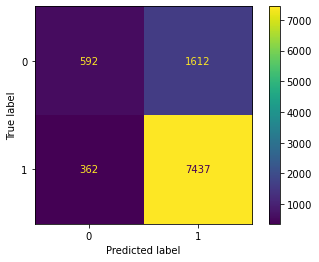

In [50]:
#get predictions 
preds = gs.predict(X_test_tvec)

#plot confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot();

In [51]:
print(f'ROC AUC: {roc_auc_score(y_test, preds)}')
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

ROC AUC: 0.6110931668143968
Accuracy: 0.8026592022393282
F1 Score: 0.8828347578347578


In [52]:
print('***************Classification Report*****************')
print(classification_report(y_test, preds))

***************Classification Report*****************
              precision    recall  f1-score   support

           0       0.62      0.27      0.37      2204
           1       0.82      0.95      0.88      7799

    accuracy                           0.80     10003
   macro avg       0.72      0.61      0.63     10003
weighted avg       0.78      0.80      0.77     10003



#### Gridsearch with TVEC NGram Range & LR Solver Variation

In [53]:
#set up gridsearch
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(C=1, n_jobs = -2))
])

pipe_tvec_params = {
    'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
    'lr__solver' : ['liblinear', 'lbfgs']
}


gs_tvec = GridSearchCV(pipe_tvec,
                 param_grid=pipe_tvec_params,
                 cv=5)

gs_tvec.fit(X_train, y_train)

training_score = gs_tvec.score(X_train, y_train)
testing_score = gs_tvec.score(X_test, y_test)
cv_score = cross_val_score(gs_tvec, X_train, y_train, cv=5).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs_tvec.best_params_)

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  warnings.warn("

Training Score is:  0.833258348330334
Testing Score is:  0.8067579726082176
Cross-val score is: 0.8012398850043769.
{'lr__solver': 'lbfgs', 'tvec__ngram_range': (1, 2)}


| Metric 	| Value 	|
|-	|-	|
| Training Score 	| 0.833258348330334 	|
| Testing Score 	| 0.8067579726082176 	|
| Cross-val score 	| 0.8012398850043769 	|
| Best Params 	| {'lr__solver': 'lbfgs', 'tvec__ngram_range': (1, 2)} 	|

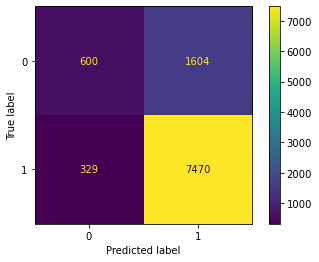

In [59]:
#get predictions 
preds = gs_tvec.predict(X_test)

#plot confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot();

In [60]:
print(f'ROC AUC: {roc_auc_score(y_test, preds)}')
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

ROC AUC: 0.6150237047003793
Accuracy: 0.8067579726082176
F1 Score: 0.8854382741658271


In [61]:
print('***************Classification Report*****************')
print(classification_report(y_test, preds))

***************Classification Report*****************
              precision    recall  f1-score   support

           0       0.65      0.27      0.38      2204
           1       0.82      0.96      0.89      7799

    accuracy                           0.81     10003
   macro avg       0.73      0.62      0.63     10003
weighted avg       0.78      0.81      0.77     10003



In [66]:
#set up gridsearch with feature limits
pipe_tvec2 = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range = (1, 2), max_features=6_000)),
    ('lr', LogisticRegression(n_jobs = -2))
])

pipe_tvec2_params = {
    'lr__C' : [0.1, 1, 10]
}


gs_tvec2 = GridSearchCV(pipe_tvec2,
                 param_grid=pipe_tvec2_params,
                 cv=5)

gs_tvec2.fit(X_train, y_train)

training_score = gs_tvec2.score(X_train, y_train)
testing_score = gs_tvec2.score(X_test, y_test)
cv_score = cross_val_score(gs_tvec2, X_train, y_train, cv=5).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs_tvec2.best_params_)

Training Score is:  0.8140371925614877
Testing Score is:  0.803558932320304
Cross-val score is: 0.7990903317790099.
{'lr__C': 1}


The bias and variance seem to have leveled off here. 

| Metric 	| Value 	|
|-	|-	|
| Training Score 	| 0.8140371925614877 	|
| Testing Score 	| 0.803558932320304 	|
| Cross-val score 	| 0.7990903317790099 	|
| Best Params 	| {'lr__C': 1} 	|

### Random Forest

In [67]:
pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer(max_features=6_000)),
    ('rf', RandomForestClassifier(n_jobs = -2))
])

pipe_rf_params = {
    'tvec__ngram_range' : [(1,2), (1, 3)],
    'rf__n_estimators': [200, 300],
    'rf__min_samples_leaf': [1, 2],
    'rf__bootstrap' : [True]
}

gs_rf = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=3)

gs_rf.fit(X_train, y_train)

training_score = gs_rf.score(X_train, y_train)
testing_score = gs_rf.score(X_test, y_test)
cv_score = cross_val_score(gs_rf, X_train, y_train, cv=3).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs_rf.best_params_)

Training Score is:  0.9523595280943811
Testing Score is:  0.795261421573528
Cross-val score is: 0.7903419316136772.
{'rf__bootstrap': True, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200, 'tvec__ngram_range': (1, 2)}


| Metric 	| Value 	|
|-	|-	|
| Training Score 	| 0.9523595280943811 	|
| Testing Score 	| 0.795261421573528 	|
| Cross-val score 	| 0.7903419316136772 	|
| Best Params 	| {'rf__bootstrap': True, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200, 'tvec__ngram_range': (1, 2)} 	|

In [69]:
pipe_rf2 = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range = (1, 2), max_features=6_000)),
    ('rf', RandomForestClassifier(n_jobs = -2, min_samples_leaf = 2, n_estimators=200))
])

pipe_rf2_params = {
    'rf__min_samples_split': [2, 3],
    'rf__max_features' : ['auto', 'sqrt'],
    'tvec__min_df' : [2,3,5],
}

gs_rf2 = GridSearchCV(pipe_rf2,
                     param_grid=pipe_rf2_params,
                     cv=3)

gs_rf2.fit(X_train, y_train)

training_score = gs_rf2.score(X_train, y_train)
testing_score = gs_rf2.score(X_test, y_test)
cv_score = cross_val_score(gs_rf2, X_train, y_train, cv=3).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs_rf2.best_params_)

Training Score is:  0.9528844231153769
Testing Score is:  0.7964610616814956
Cross-val score is: 0.7901919616076785.
{'rf__max_features': 'auto', 'rf__min_samples_split': 3, 'tvec__min_df': 3}


| Metric 	| Value 	|
|-	|-	|
| Training Score 	| 0.9528844231153769 	|
| Testing Score 	| 0.7964610616814956 	|
| Cross-val score 	| 0.7901919616076785 	|
| Best Params 	| {'rf__max_features': 'auto', 'rf__min_samples_split': 3, 'tvec__min_df': 3} 	|

In [70]:
pipe_rf3 = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range = (1, 2))),
    ('rf', RandomForestClassifier(n_jobs = -2, min_samples_split= 3 , min_samples_leaf = 2))
])

pipe_rf3_params = {
    'rf__n_estimators': [200, 400],
}

gs_rf3 = GridSearchCV(pipe_rf3,
                     param_grid=pipe_rf3_params,
                     cv=3,
                     verbose=1)

gs_rf3.fit(X_train, y_train)

training_score = gs_rf3.score(X_train, y_train)
testing_score = gs_rf3.score(X_test, y_test)
cv_score = cross_val_score(gs_rf3, X_train, y_train, cv=3).mean()
print(f'Training Score is:  {training_score}')
print(f'Testing Score is:  {testing_score}')
print(f'Cross-val score is: {cv_score}.')

print(gs_rf3.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.6s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   56.1s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   56.3s finished


Training Score is:  0.8278594281143771
Testing Score is:  0.7904628611416575
Cross-val score is: 0.7879424115176965.
{'rf__n_estimators': 200}
